## Libraries

In [24]:
%matplotlib inline

In [1]:
import torch
import os
import torchvision
import tarfile

In [7]:
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

In [8]:
import torch.nn as nn

In [9]:
from torch.nn import functional as F

In [10]:
from itertools import chain

## Download the train and test Dataset

In [13]:
train_set = torchvision.datasets.FashionMNIST("/usr", download=True, transform = transforms.Compose ([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, transform = transforms.Compose ([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



## Split the training set to train and validation

In [16]:
train_size = 48000
val_size = 60000 - train_size
train_ds, val_ds = random_split(train_set,[train_size,val_size])


In [19]:
train_dl = DataLoader(train_ds,batch_size=20,
                     shuffle=True)
val_dl = DataLoader(val_ds, batch_size=20,
                   shuffle=True)
classes = train_set.classes

In [74]:
## test dl
test_dl = DataLoader(test_set,batch_size=20, shuffle=True)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

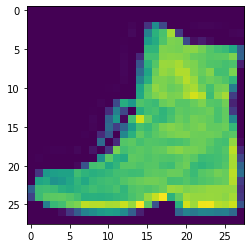

In [42]:
for imgs,labels in train_dl:
    for img in imgs:
        arr_ = np.squeeze(img)
        # plt has imshow to visualize an image
        plt.imshow(arr_)
        plt.show()
        break
    break

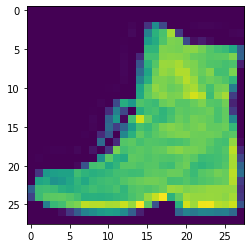

In [44]:
plt.imshow(arr_)
plt.show()

In [48]:
np.shape(arr_)

torch.Size([28, 28])

## Defining the architecture

In [45]:
import torch.nn as nn

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #convolutional layer-1
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, 
        #                 padding_mode='zeros', device=None, dtype=None)
        self.conv1 = nn.Conv2d(1,6,5, padding =0)
        #convolutional layer-2
        self.conv2 = nn.Conv2d(6,10,5, padding =0)
        # max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Fully connected layer 1
        self.ff1 = nn.Linear(4*4*10,56)
        # Fully connected layer 2
        self.ff2 = nn.Linear(56,10)
    def forward(self, x):
        # adding sequence of convolutional and max pooling layers
        #input dim-28*28*1
        x = self.conv1(x)
        # After convolutional operation, output dim - 24*24*6
        x = self.pool(x)
        # After Max pool operation output dim - 12*12*6
        x = self.conv2(x)
        # After convolution operation output dim - 8*8*10
        x = self.pool(x)
        # max pool output dim 4*4*10
        x = x.view(-1,4*4*10) # Reshaping the values to a shape appropriate to the input of fully connected layer
        x = F.relu(self.ff1(x)) # Applying Relu to the output of first layer
        x = F.sigmoid(self.ff2(x)) # Applying sigmoid to the output of second lyaer
        return x

In [53]:
# create a complete CNN
model_scratch = Net()
print(model_scratch)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ff1): Linear(in_features=160, out_features=56, bias=True)
  (ff2): Linear(in_features=56, out_features=10, bias=True)
)


In [55]:
# move tensors to GPU if CUDA if available
use_cuda = False
if use_cuda:
    model_scratch.cuda()

## Define the loss function

In [56]:
# Loss function
import torch.optim as optim
criterion_scratch = nn.CrossEntropyLoss()
def get_optimizer_scratch(model):
    # lr : learning rate
    optimizer = optim.SGD(model.parameters(),lr=0.04)
    return optimizer

## Implementing the training and validation algorithm

In [65]:
# Implementing the training algorithm
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """ returns trained model """
    # initialize tracker for minimum validation losss
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        # train phase #
        # setting the module to training mode
        model.train()
        for batch_idx, (data,target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1/(batch_idx+1))*(loss.data.item()-train_loss))
            
        # validate the model #
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data,target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output,target)
            valid_loss = valid_loss + ((1/(batch_idx+1))*(loss.data.item()-train_loss))
        
    # print training/validation statistics
        print('Epoch:{} tTraining Loss: {:.6f} tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss        
        ))
    ## If the validation loss has decreased, then saving the model
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    return model

## Training and evaluation phase

In [77]:
num_epochs = 15
loaders_scratch={'train':train_dl, 'valid':val_dl,'test':test_dl}

In [71]:

model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                     criterion_scratch,use_cuda,'model_scratch.pt')

Epoch:1 tTraining Loss: 1.622885 tValidation Loss: 0.022481
Validation loss decreased (inf --> 0.022481). Saving model ...
Epoch:2 tTraining Loss: 1.611872 tValidation Loss: -0.144973
Validation loss decreased (0.022481 --> -0.144973). Saving model ...
Epoch:3 tTraining Loss: 1.602282 tValidation Loss: -0.038702
Epoch:4 tTraining Loss: 1.597876 tValidation Loss: 0.024819
Epoch:5 tTraining Loss: 1.593977 tValidation Loss: 0.023242
Epoch:6 tTraining Loss: 1.591241 tValidation Loss: -0.006300
Epoch:7 tTraining Loss: 1.588254 tValidation Loss: -0.044724
Epoch:8 tTraining Loss: 1.585891 tValidation Loss: 0.097368
Epoch:9 tTraining Loss: 1.583816 tValidation Loss: 0.019571
Epoch:10 tTraining Loss: 1.581387 tValidation Loss: 0.048001
Epoch:11 tTraining Loss: 1.579709 tValidation Loss: 0.047539
Epoch:12 tTraining Loss: 1.577670 tValidation Loss: 0.024843
Epoch:13 tTraining Loss: 1.576494 tValidation Loss: 0.063003
Epoch:14 tTraining Loss: 1.573826 tValidation Loss: 0.024136
Epoch:15 tTraining 

## Testing Phase

In [78]:
def test(loaders, model, criterion, use_cuda):
    
    #monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    # set the module to evaluation mode
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1/(batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1,keepdim=True)[1]
        #compare predicitons to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred)), axis =1).cpu().numpy())
        total +=data.size(0)
    print('Test Loss: {:.6f}n'.format(test_loss))
    print('nTest Accuracy: %2d%% (%2d/%2d)' %(
        100. * correct / total, correct, total))
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)


Test Loss: 1.603347n
nTest Accuracy: 72% (43682/60000)


## Testing with a sample

In [79]:
def predict_image(img,model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # printing the image
    plt.imshow(img.squeeze())
    # returning the class label related to the image
    return train_set.classes[preds[0].item()]

'T-shirt/top'

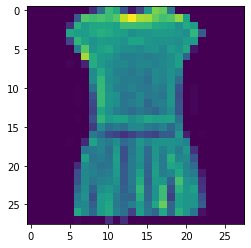

In [91]:
img,label = test_set[3]
predict_image(img,model_scratch)

In [87]:
test_set.item()

AttributeError: 'FashionMNIST' object has no attribute 'item'